# Code for generating and running PH of noisy networks - dev

In [ ]:
# Need to load in all the network generation functions here?



In [1]:
# Load packages

using Pkg
using Statistics
using Plots
using LinearAlgebra
using Distances
using Eirene
using StatsBase
using Random
using Distributions
using JLD
using MAT

function is_symmetric(adj)
    tf = isequal(adj,transpose(adj))
    if !tf
        println("Matrix is not symmetric!")
    end
    return tf
end


function make_iid_weighted_graph(nNodes)
    
    adj = rand(nNodes,nNodes)
    for i = 1:nNodes, j = 1:nNodes
        # symmetrize
        adj[j,i] = adj[i,j]
    end
    
    # Set diagonal to 0
    adj[diagind(adj)] .= 0
    
    # Check for symmetry
    tf = is_symmetric(adj)
    
    # Return adjacency matrix
    return adj
end
    

function make_random_geometric(nNodes,dims)
    
    # Generate random coordinates in [0,1)^dims
    randomCoordinates = rand(dims,nNodes)
    
    # Compute pairwise distances between nodes (points in [0,1)^dims)
    adj = pairwise(Euclidean(), randomCoordinates, dims = 2)
    adj = 1 ./adj
    adj[diagind(adj)] .= 0
    
    # Check for symmetry
    tf = is_symmetric(adj)
    
    return adj
end


function check_density(G)
    
    # Determine number of nodes and edges
    nNodes = size(G,1)
    nPosEdges = length(G[G.> 0])./2    # Divide by 2 because this counts upper and lower triangular edges
    

    # Calculate the edge density as the number of nonzero edges over the total possible
    edge_density = nPosEdges./binomial(nNodes,2)
    
    return edge_density
end


function threshold_graph(G,rho,nNodes)
    
    # Count edges and edges we need to keep
    nEdges = binomial(nNodes,2)
    thresh_edge_number = ceil(Int,rho*nEdges)
    
    # Obtain value on which to threshold
    sorted_edges = sort(unique([G...]),rev = true)
    thresh_edge_value = sorted_edges[thresh_edge_number]
    
    # Make copy and threshold G
    G_thresh = deepcopy(G)
    G_thresh[G_thresh.< thresh_edge_value] .= 0
    
    # Test graph density
    rho_test = check_density(G_thresh)
    #println("Graph edge density is $rho_test")
    
    return G_thresh
end


function betticurveFromBarcode(barcode,nSteps)
    # nSteps will be nEdges here

    betti_curve = zeros(1,nSteps)   # Column-major order

    for bar in eachrow(barcode)
    
        bar_first = Int(bar[1])
        bar_last = Int(bar[2]) 
    
        # Add to betti curve
        betti_curve[1,bar_first:bar_last] = betti_curve[1,bar_first:bar_last] .+1 
    end
    
    return betti_curve
end

function make_ring_lattice_wei(nNodes)
    # Create weighted ring lattice
    
    if !iseven(nNodes)
        v = ones(1,(nNodes-1)) ./ [transpose(collect(1:floor(nNodes/2))) transpose(reverse(collect(1:floor(nNodes/2))))]
        v = [0 v]
        adj = deepcopy(v)
        for n in 1:(nNodes-1)
            adj = [adj; zeros(1,n) transpose(v[1,1:(nNodes-n)])]
        end
        adj = adj .+ (1/(nNodes^4))*rand(nNodes,nNodes)
        adj = adj+transpose(adj)
        adj[diagind(adj)].=0
        
        
    end
    
    return adj
end


function make_cosine_geometric(nNodes,dims)
    
    # Generate random coordinates in [0,1)^dims
    randomCoordinates = rand(dims,nNodes)
    
    # Compute pairwise distances between nodes (points in [0,1)^dims)
    adj = pairwise(CosineDist(), randomCoordinates, dims = 2)
    
    # Check for symmetry
    tf = is_symmetric(adj)
    
    return adj
end




function make_dot_product(nNodes,dims)
    # Generate random coordinates in [0,1)^dims
    randomCoordinates = rand(dims,nNodes)
    
    # Compute pairwise distances between nodes (points in [0,1)^dims)
    adj = randomCoordinates' * randomCoordinates
    
    # Check for symmetry
    tf = is_symmetric(adj)
    
    return adj
end


function make_dumb_2modular(nNodes,p_in,p_out)
    
    adj = zeros(nNodes,nNodes)
    
    community_assignments = [ones(1,Int(nNodes/2)) 2*ones(1,Int(nNodes/2))]
    
    for n1 in 1:nNodes
        for n2 in n1:nNodes
            
            if isequal(community_assignments[n1],community_assignments[n2])
                
                we = 0
                r = rand(1,1)[1]
                
                while r < p_in
                    we = we+1
                    r = rand(1,1)[1]
                end
                
                adj[n1,n2] = we + 0.0001*rand(1,1)[1]
                adj[n2,n1] = adj[n1,n2]
                
            else
                
                we = 0
                r = rand(1,1)[1]
                
                while r < p_out
                    we = we+1
                    r = rand(1,1)[1]
                end
                
                adj[n1,n2] = we + 0.0001*rand(1,1)[1]
                adj[n2,n1] = adj[n1,n2]
            end
            
        end
    end
    
     # Check for symmetry
    tf = is_symmetric(adj)
    
    return adj
end

   


    
function make_dumb_4modular(nNodes,p_in,p_out)
    
    adj = zeros(nNodes,nNodes)
    
    community_assignments = [ones(1,Int(nNodes/4)) 2*ones(1,Int(nNodes/4)) 3*ones(1,Int(nNodes/4)) 4*ones(1,Int(nNodes/4))]
    
    for n1 in 1:nNodes
        for n2 in n1:nNodes
            
            if isequal(community_assignments[n1],community_assignments[n2])
                
                we = 0
                r = rand(1,1)[1]
                
                while r < p_in
                    we = we+1
                    r = rand(1,1)[1]
                end
                
                adj[n1,n2] = we + 0.0001*rand(1,1)[1]
                adj[n2,n1] = adj[n1,n2]
                
            else
                
                we = 0
                r = rand(1,1)[1]
                
                while r < p_out
                    we = we+1
                    r = rand(1,1)[1]
                end
                
                adj[n1,n2] = we + 0.0001*rand(1,1)[1]
                adj[n2,n1] = adj[n1,n2]
            end
            
        end
    end
    
    # Check for symmetry
    tf = is_symmetric(adj)
    
    return adj
end




function make_dev_DiscreteUniform_configuration_model(nNodes,a,b)
    
    # Create a configuration model using the discrete uniform distribution between a and b.
    
    # Define distribution
    d = DiscreteUniform(a,b)
    strength_sequence = rand(d,nNodes)

    stubs = deepcopy(strength_sequence)
    adj = zeros(nNodes,nNodes)

    nodes_left = []
    # While stubs are left
    while sum(stubs)>0

        # Find which nodes have stubs left
        nodes_left = findall(stubs.>0)

        # If only one node is left, we did badly
        if length(nodes_left) == 1
            println("One node left - try again")
            
            # Currently this is a draft so we will allow it.
            break
        end


        # nodes_left contains cartesian indices. Can access them with nodes_left[i][j]. Not anymore
        node1,node2 = sample(nodes_left,2, replace = false)

        # Add edge to adjacency matrix
        adj[node1, node2] = adj[node1, node2] + 1 

        # Update stubs
        stubs[node1] = stubs[node1] - 1
        stubs[node2] = stubs[node2] - 1

        
    end

    # Now we only added edges to one side of the adjacency matrix.
    adj = adj+adj'
    
    # Add noise
    adj = adj .+ (1/(nNodes^4))*rand(nNodes,nNodes)
    adj = adj+transpose(adj)
    adj[diagind(adj)].=0
    
    # Check for symmetry
    tf = is_symmetric(adj)
    
    return adj
end





function make_dev_Geometric_configuration_model(nNodes,p,scale_factor)
    
    # Create a configuration model using the Geometric distribution with parameter p. To get enough edges,
    # scale by scale_factor
    
    # Define distribution
    d = Geometric(p)
    strength_sequence = scale_factor*rand(d,nNodes)

    stubs = deepcopy(strength_sequence)
    adj = zeros(nNodes,nNodes)

    nodes_left = []
    # While stubs are left
    while sum(stubs)>0

        # Find which nodes have stubs left
        nodes_left = findall(stubs.>0)

        # If only one node is left, we did badly
        if length(nodes_left) == 1
            println("One node left - try again")
            
            # Currently this is a draft so we will allow it.
            break
        end


        # nodes_left contains cartesian indices. Can access them with nodes_left[i][j]. Not anymore
        node1,node2 = sample(nodes_left,2, replace = false)

        # Add edge to adjacency matrix
        adj[node1, node2] = adj[node1, node2] + 1 

        # Update stubs
        stubs[node1] = stubs[node1] - 1
        stubs[node2] = stubs[node2] - 1

        
    end

    # Now we only added edges to one side of the adjacency matrix.
    adj = adj+adj'
    
    # Add noise
    adj = adj .+ (1/(nNodes^4))*rand(nNodes,nNodes)
    adj = adj+transpose(adj)
    adj[diagind(adj)].=0
    
    # Check for symmetry
    tf = is_symmetric(adj)
    
    return adj
end







┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1242
┌ Info: Precompiling Distances [b4f34e82-e78d-54a5-968a-f98e89d6e8f7]
└ @ Base loading.jl:1242
┌ Info: Precompiling Eirene [9c0f25c4-2ca1-5870-89f6-52640788da1d]
└ @ Base loading.jl:1242


HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-1093934362832152373\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-16537292538932940364\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio-jupyter-notebook\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<p\n    id=\"webio-warning-1093934362832152373\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    For troubleshooting, please see <a href=\"https://juliagizmos.github.io/WebIO.jl/latest/providers/ijulia/\">\n    the WebIO/IJulia documentation</a>.\n    <!-- TODO: link to installation docs. -->\n</p>\n")

┌ Info: Precompiling Distributions [31c24e10-a181-5473-b8eb-7969acd0382f]
└ @ Base loading.jl:1242


make_dev_Geometric_configuration_model (generic function with 1 method)

## Choose weighed network and generate replicates

--------------------------------
## CHANGE PARAMETERS HERE
---------------------------------

In [17]:
## Pick from one of the graph models and generate out to THRESH edge density

const NREPS = 5
const RHO = 0.5      # Threshold at edge density = rho
const NNODES = 80
const SAVE_FIGURES = 1  # Boolean to save figure pdfs
const SAVE_DATA = 0    # Boolean to save data  

# for geometricConf
const P = 0.01
const SCALE_FACTOR = 100

# for RG
const DIMS = 3

# for discreteUniformConf
const A = 0
const B = 1000

# for cosineGeometric
# dims = 3


# Graph model name one of "geometricConf", "IID" , "RG", "discreteUniformConf", "cosineGeometric", "RL", "SWBM"
const GRAPH_MODEL_NAME = "geometricConf"

"geometricConf"

In [64]:
using MAT
function construct_graphs(nNodes,nReps,rho,p,scale_factor, dims, a, b, graph_model_name,save_data)

    weighted_graph_array = Array{Union{Missing, Float64}}(missing, nNodes, nNodes, nReps)
    weighted_graph_array_ord = Array{Union{Missing, Float64}}(missing, nNodes, nNodes, nReps)
    betti_file_name = []
    parameters = []
    for rep in 1:nReps


        if graph_model_name == "geometricConf"
            G_i = make_dev_Geometric_configuration_model(nNodes,p,scale_factor)
            parameters = [nReps, rho, nNodes, p, scale_factor]
            betti_file_name = "$(graph_model_name)"

            for parameter in parameters
                betti_file_name = "$(betti_file_name)_$(replace(string(parameter),"." => ""))"
            end


        elseif graph_model_name == "IID"
            G_i = make_iid_weighted_graph(nNodes)
            parameters = [nReps, rho, nNodes]
            betti_file_name = "$(graph_model_name)"

            for parameter in parameters
                betti_file_name = "$(betti_file_name)_$(replace(string(parameter),"." => ""))"
            end


        elseif graph_model_name == "RG"
            G_i = make_random_geometric(nNodes,dims)
            parameters = [nReps, rho, nNodes, dims]
            betti_file_name = "$(graph_model_name)"

            for parameter in parameters
                betti_file_name = "$(betti_file_name)_$(replace(string(parameter),"." => ""))"
            end


        elseif graph_model_name == "discreteUniformConf"
            G_i = make_dev_DiscreteUniform_configuration_model(nNodes,a,b)
            parameters = [nReps, rho, nNodes, a, b]
            betti_file_name = "$(graph_model_name)"

            for parameter in parameters
                betti_file_name = "$(betti_file_name)_$(replace(string(parameter),"." => ""))"
            end


        elseif graph_model_name == "cosineGeometric"
            G_i = make_cosine_geometric(nNodes,dims)
            parameters = [nReps, rho, nNodes, dims]
            betti_file_name = "$(graph_model_name)"

            for parameter in parameters
                betti_file_name = "$(betti_file_name)_$(replace(string(parameter),"." => ""))"
            end


        elseif graph_model_name == "RL"
            G_i = make_ring_lattice_wei(nNodes)
            parameters = [nReps, rho, nNodes]
            betti_file_name = "$(graph_model_name)"

            for parameter in parameters
                betti_file_name = "$(betti_file_name)_$(replace(string(parameter),"." => ""))"
            end


        elseif graph_model_name == "ASSOC"
            println("load data you fool")
        end




        # Threshold at rho
        G_i_thresh = threshold_graph(G_i,rho,nNodes)

        weighted_graph_array[:,:,rep] = G_i_thresh


        edge_list_ranks = denserank([G_i...], rev = true)   # so highest edge weight gets assigned 1
        G_i_ord = reshape(edge_list_ranks,(nNodes,nNodes))
        G_i_ord[diagind(G_i_ord)] .= 0
        weighted_graph_array_ord[:,:,rep] = G_i_ord




    end
    println("Naming files $(betti_file_name)")

    # We can add noise to the entire array at the same time

    weighted_graph_array_iidNoise = deepcopy(weighted_graph_array)
    weighted_graph_array_iidNoise_ord = Array{Union{Missing, Float64}}(missing, nNodes, nNodes, nReps)
    for rep in 1:nReps

        G_i = weighted_graph_array_iidNoise[:,:,rep]
        G_i[G_i.>0] .= G_i[G_i .>0 ] .+1

        # Now the real values are all >1, so we can add noise which will be < 1

        G_rand = make_iid_weighted_graph(nNodes)
        G_i_rand = deepcopy(G_i)
        G_i_rand[G_i_rand .== 0] .= G_rand[G_i_rand .== 0]

        # So anything <1 in G_i_rand will be from random noise, and any entry >1 will be real matrix

        weighted_graph_array_iidNoise[:,:,rep] = G_i_rand


        # Now create the ranked matrix for running eirene -- it will save us many headaches later.
        edge_list_ranks = denserank([G_i_rand...], rev = true)   # so highest edge weight gets assigned 1
        G_i_rand_ord = reshape(edge_list_ranks,(nNodes,nNodes))
        G_i_rand_ord[diagind(G_i_rand_ord)] .= 0


        weighted_graph_array_iidNoise_ord[:,:,rep] = G_i_rand_ord



    end
    
    return weighted_graph_array, weighted_graph_array_iidNoise, weighted_graph_array_iidNoise_ord 
end




weighted_graph_array, weighted_graph_array_iidNoise, weighted_graph_array_iidNoise_ord = construct_graphs(NNODES,NREPS,RHO,p,scale_factor, dims, a, b, GRAPH_MODEL_NAME,SAVE_DATA)
    
# Plot an example weighted graph and after we add noise

# gr()

# test_mat = 2
# p0a = heatmap(weighted_graph_array[:,:,test_mat], aspect_ratio = :equal)
# p0b = heatmap(weighted_graph_array_iidNoise[:,:,test_mat], aspect_ratio = :equal)
# p0c = heatmap(weighted_graph_array_iidNoise_ord[:,:,test_mat], aspect_ratio = :equal)

# plot(p0a,p0b,p0c,layout = (1,3))


# if SAVE_FIGURES == 1
#     savefig("../Figures/$(betti_file_name).pdf")
# end

# if SAVE_DATA == 1
#     save("../processed_data/$(betti_file_name)_graphs.jld",
#      "weighted_graph_array", weighted_graph_array,
#      "weighted_graph_array_iidNoise", weighted_graph_array_iidNoise,
#      "parameters", parameters)
# end

println("done:>")

Naming files IID_50_05_800
done:>


In [18]:
function edge_weights_to_order(G_i,nNodes)
    edge_list_ranks = denserank([G_i...], rev = true)   # so highest edge weight gets assigned 1
    G_i_ord = reshape(edge_list_ranks,(nNodes,nNodes))
    G_i_ord[diagind(G_i_ord)] .= 0
    
    return G_i_ord
end

function construct_graphs(nNodes,nReps,rho,p,scale_factor, dims, a, b, graph_model_name,save_data)

    weighted_graph_array = Array{Union{Missing, Float64}}(missing, nNodes, nNodes, nReps)
    weighted_graph_array_ord = Array{Union{Missing, Float64}}(missing, nNodes, nNodes, nReps)
    betti_file_name = []
    parameters = []



    if graph_model_name == "geometricConf"
        for rep in 1:nReps

            # Construct the graph and fill weighted graph array
            G_i = make_dev_Geometric_configuration_model(nNodes,p,scale_factor)

            # Threshold at rho and fill weighted_graph_array
            weighted_graph_array[:,:,rep] = threshold_graph(G_i,rho,nNodes)

            # Order edges and fill weighted_graph_array_ord
            weighted_graph_array_ord[:,:,rep] = edge_weights_to_order(G_i,nNodes)
        end

        parameters = [nReps, rho, nNodes, p, scale_factor]
        betti_file_name = "$(graph_model_name)"

        for parameter in parameters
            betti_file_name = "$(betti_file_name)_$(replace(string(parameter),"." => ""))"
        end


    elseif graph_model_name == "IID"
        for rep in 1:nReps
            # Construct the graph and fill weighted graph array
            G_i = make_iid_weighted_graph(nNodes)

            # Threshold at rho and fill weighted_graph_array
            weighted_graph_array[:,:,rep] = threshold_graph(G_i,rho,nNodes)

            # Order edges and fill weighted_graph_array_ord
            weighted_graph_array_ord[:,:,rep] = edge_weights_to_order(G_i,nNodes)
        end

        parameters = [nReps, rho, nNodes]
        betti_file_name = "$(graph_model_name)"

        for parameter in parameters
            betti_file_name = "$(betti_file_name)_$(replace(string(parameter),"." => ""))"
        end


    elseif graph_model_name == "RG"
        for rep in 1:nReps

            # Construct the graph and fill weighted graph array
            G_i = make_random_geometric(nNodes,dims)

            # Threshold at rho and fill weighted_graph_array
            weighted_graph_array[:,:,rep] = threshold_graph(G_i,rho,nNodes)

            # Order edges and fill weighted_graph_array_ord
            weighted_graph_array_ord[:,:,rep] = edge_weights_to_order(G_i,nNodes)

        end

        parameters = [nReps, rho, nNodes, dims]
        betti_file_name = "$(graph_model_name)"

        for parameter in parameters
            betti_file_name = "$(betti_file_name)_$(replace(string(parameter),"." => ""))"
        end


    elseif graph_model_name == "discreteUniformConf"
        for rep in 1:nReps

            # Construct the graph and fill weighted graph array
            G_i = make_dev_DiscreteUniform_configuration_model(nNodes,a,b)

            # Threshold at rho and fill weighted_graph_array
            weighted_graph_array[:,:,rep] = threshold_graph(G_i,rho,nNodes)

            # Order edges and fill weighted_graph_array_ord
            weighted_graph_array_ord[:,:,rep] = edge_weights_to_order(G_i,nNodes)

        end

        parameters = [nReps, rho, nNodes, a, b]
        betti_file_name = "$(graph_model_name)"

        for parameter in parameters
            betti_file_name = "$(betti_file_name)_$(replace(string(parameter),"." => ""))"
        end


    elseif graph_model_name == "cosineGeometric"
        for rep in 1:nReps

            # Construct the graph and fill weighted graph array
            G_i = make_cosine_geometric(nNodes,dims)

            # Threshold at rho and fill weighted_graph_array
            weighted_graph_array[:,:,rep] = threshold_graph(G_i,rho,nNodes)

            # Order edges and fill weighted_graph_array_ord
            weighted_graph_array_ord[:,:,rep] = edge_weights_to_order(G_i,nNodes)

        end
        G_i = make_cosine_geometric(nNodes,dims)
        parameters = [nReps, rho, nNodes, dims]
        betti_file_name = "$(graph_model_name)"

        for parameter in parameters
            betti_file_name = "$(betti_file_name)_$(replace(string(parameter),"." => ""))"
        end


    elseif graph_model_name == "RL"
         for rep in 1:nReps

            # Construct the graph and fill weighted graph array
            G_i = make_ring_lattice_wei(nNodes)

            # Threshold at rho and fill weighted_graph_array
            weighted_graph_array[:,:,rep] = threshold_graph(G_i,rho,nNodes)

            # Order edges and fill weighted_graph_array_ord
            weighted_graph_array_ord[:,:,rep] = edge_weights_to_order(G_i,nNodes)

        end

        parameters = [nReps, rho, nNodes]
        betti_file_name = "$(graph_model_name)"

        for parameter in parameters
            betti_file_name = "$(betti_file_name)_$(replace(string(parameter),"." => ""))"
        end


    elseif graph_model_name == "ASSOC"
        println("load data you fool")
    end






    #     end
    println("Naming files $(betti_file_name)")

        # We can add noise to the entire array at the same time
    ## THis should be a function!!!
    weighted_graph_array_iidNoise = deepcopy(weighted_graph_array)
    weighted_graph_array_iidNoise_ord = Array{Union{Missing, Float64}}(missing, nNodes, nNodes, nReps)
    for rep in 1:nReps

        G_i = weighted_graph_array_iidNoise[:,:,rep]
        G_i[G_i.>0] .= G_i[G_i .>0 ] .+1

        # Now the real values are all >1, so we can add noise which will be < 1

        G_rand = make_iid_weighted_graph(nNodes)
        G_i_rand = deepcopy(G_i)
        G_i_rand[G_i_rand .== 0] .= G_rand[G_i_rand .== 0]

        # So anything <1 in G_i_rand will be from random noise, and any entry >1 will be real matrix

        weighted_graph_array_iidNoise[:,:,rep] = G_i_rand


        # Now create the ranked matrix for running eirene -- it will save us many headaches later.
        edge_list_ranks = denserank([G_i_rand...], rev = true)   # so highest edge weight gets assigned 1
        G_i_rand_ord = reshape(edge_list_ranks,(nNodes,nNodes))
        G_i_rand_ord[diagind(G_i_rand_ord)] .= 0


        weighted_graph_array_iidNoise_ord[:,:,rep] = G_i_rand_ord



    end
    
    return weighted_graph_array, weighted_graph_array_iidNoise, weighted_graph_array_iidNoise_ord 
end



construct_graphs (generic function with 1 method)

One node left - try again
One node left - try again
One node left - try again
One node left - try again
One node left - try again
Naming files geometricConf_50_05_800_001_1000


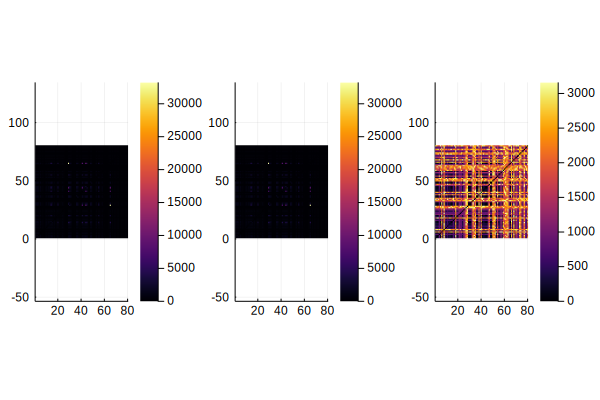

In [20]:
# using MAT
# nNodes = 21
# nReps = NREPS
# p = P
# scale_factor = SCALE_FACTOR
# rho = RHO
# graph_model_name = "RL"
# dims = DIMS



weighted_graph_array, weighted_graph_array_iidNoise, weighted_graph_array_iidNoise_ord = construct_graphs(NNODES,NREPS,RHO,P,SCALE_FACTOR, DIMS, A, B, GRAPH_MODEL_NAME,SAVE_DATA)
    
# Plot an example weighted graph and after we add noise

gr()

test_mat = 2
p0a = heatmap(weighted_graph_array[:,:,test_mat], aspect_ratio = :equal)
p0b = heatmap(weighted_graph_array_iidNoise[:,:,test_mat], aspect_ratio = :equal)
p0c = heatmap(weighted_graph_array_iidNoise_ord[:,:,test_mat], aspect_ratio = :equal)

plot(p0a,p0b,p0c,layout = (1,3))


# if SAVE_FIGURES == 1
#     savefig("../Figures/$(betti_file_name).pdf")
# end

# if SAVE_DATA == 1
#     save("../processed_data/$(betti_file_name)_graphs.jld",
#      "weighted_graph_array", weighted_graph_array,
#      "weighted_graph_array_iidNoise", weighted_graph_array_iidNoise,
#      "parameters", parameters)
# end

# println("done:)")

In [56]:
ar = Array{Union{Missing, Array}}(missing, 2)
ar[1] = zeros(2,2)
ar[2] = ones(2,3)
sum.(ar)

2-element Array{Float64,1}:
 0.0
 6.0

In [65]:
@time construct_graphs(NNODES,NREPS,RHO,P,SCALE_FACTOR, DIMS, A, B, GRAPH_MODEL_NAME,SAVE_DATA)

@time construct_graphs(NNODES,NREPS,RHO,p,scale_factor, dims, a, b, GRAPH_MODEL_NAME,SAVE_DATA)

println("done :)")


Naming files IID_50_05_800
  0.018622 seconds (161.10 k allocations: 9.496 MiB)
Naming files IID_50_05_800
  0.025182 seconds (161.10 k allocations: 9.496 MiB, 21.41% gc time)
done :)


## Running Eirene

In [67]:
wgaio = Array{Union{Missing, Array}}(missing, NREPS)
for rep = 1:NREPS
    wgaio[rep] = weighted_graph_array_iidNoise_ord[:,:,rep]
end


function broadcast_eirene(wgaio,MAXDIM)
    running_eirene.(wgaio,MAXDIM)
end

@time broadcast_eirene(wgaio,MAXDIM)
@time broadcast_eirene(wgaio,MAXDIM)

 88.192449 seconds (67.03 M allocations: 21.109 GiB, 12.08% gc time)
 84.958758 seconds (67.02 M allocations: 21.109 GiB, 11.88% gc time)


5-element Array{Dict{String,Any},1}:
 Dict("symmat" => [2889 2774 … 1506 339; 2774 2889 … 2885 0; … ; 1506 2885 … 2889 984; 339 0 … 984 2889],"maxnz" => [0, 1283, 33266, 348179, 3193148, 0],"firstv" => Array{Int64,1}[[1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  72, 73, 74, 75, 76, 77, 78, 79, 80, 81], [1, 79, 149, 222, 292, 361, 431, 496, 563, 631  …  2856, 2864, 2871, 2874, 2879, 2883, 2886, 2888, 2889, 2889], [1, 2737, 4937, 7341, 9535, 11672, 13868, 15761, 17774, 19843  …  62665, 62690, 62708, 62711, 62721, 62727, 62730, 62731, 62731, 62731], [1, 57534, 98908, 146511, 187547, 227164, 268332, 301247, 337400, 374959  …  922142, 922183, 922206, 922207, 922217, 922221, 922222, 922222, 922222, 922222], [1, 815656, 934784, 1008675, 1034651, 1071964, 1081270, 1100744, 1109323, 1129176  …  1155113, 1155113, 1155113, 1155113, 1155113, 1155113, 1155113, 1155113, 1155113, 1155113], [1]],"trv" => Array{Int64,1}[[], [], [], [], [], []],"phi" => Array{Int64,1}[[], [88, 887, 433, 1569, 164, 418, 2151, 104, 

In [11]:
const MAXDIM = 3
nEdges = binomial(NNODES,2)
barcode_array = Array{Array{Float64}}(undef,NREPS,MAXDIM)
betticurve_array = zeros(nEdges,MAXDIM,NREPS)
beginTime = time()
G_i = weighted_graph_array_iidNoise_ord[:,:,2]
    
# C = Eirene.eirene(G_i,model = "vr", maxdim = MAXDIM, record = "none")

function running_eirene(G_i,MAXDIM)
    C = Eirene.eirene(G_i,model = "vr", maxdim = MAXDIM, record = "none")
    return C
end
@time C = running_eirene(G_i,MAXDIM)
@time C = running_eirene(G_i,MAXDIM)

println("done")

@time Eirene.eirene(G_i,model = "vr", maxdim = MAXDIM, record = "none")
@time Eirene.eirene(G_i,model = "vr", maxdim = MAXDIM, record = "none")

 12.847944 seconds (14.22 M allocations: 3.999 GiB, 15.82% gc time)
 13.880926 seconds (14.22 M allocations: 4.003 GiB, 18.46% gc time)
done
 12.822784 seconds (14.22 M allocations: 4.003 GiB, 17.66% gc time)
 12.461657 seconds (14.22 M allocations: 4.003 GiB, 17.80% gc time)


Dict{String,Any} with 14 entries:
  "symmat"   => [2994 2590 … 94 0; 2590 2994 … 594 296; … ; 94 594 … 2994 480; …
  "maxnz"    => [0, 1319, 35134, 581340, 20361547, 0]
  "firstv"   => Array{Int64,1}[[1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  72, 73, 74, 7…
  "trv"      => Array{Int64,1}[[], [], [], [], [], []]
  "phi"      => Array{Int64,1}[[], [163, 1955, 973, 816, 299, 574, 1548, 2858, …
  "plo"      => Array{Int64,1}[[], [16, 43, 17, 51, 9, 75, 70, 64, 48, 46  …  5…
  "ocg2rad"  => [2993.0, 2992.0, 2991.0, 2990.0, 2989.0, 2988.0, 2987.0, 2986.0…
  "farfaces" => Array{Int64,1}[[1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  71, 72, 73, 7…
  "prepairs" => Array{Int64,1}[[], [], [3, 4, 6, 8, 11, 12, 13, 17, 19, 20  …  …
  "nvl2ovl"  => [52, 80, 33, 77, 21, 76, 43, 58, 60, 71  …  73, 61, 22, 65, 35,…
  "input"    => Dict{String,Any}("genera"=>[0.0 2209.0 … 601.0 183.0; 2209.0 0.…
  "tid"      => Array{Int64,1}[[], [16, 43, 17, 51, 9, 75, 70, 64, 48, 46  …  5…
  "tcp"      => Array{Int64,1}[[1], [1, 1, 1, 1

In [66]:
function loop1(weighted_graph_array_iidNoise_ord, MAXDIM)
    b = 1
    for rep = 1:5
        G_i = weighted_graph_array_iidNoise_ord[:,:,rep]
        C = Eirene.eirene(G_i,model = "vr", maxdim = MAXDIM, record = "none")
    end
    return b
end


@time loop1(weighted_graph_array_iidNoise_ord, MAXDIM)
@time loop1(weighted_graph_array_iidNoise_ord, MAXDIM)

 92.768469 seconds (67.45 M allocations: 21.131 GiB, 11.73% gc time)
 92.890841 seconds (67.02 M allocations: 21.109 GiB, 11.47% gc time)


1

In [77]:
# barcode_array1 = Array{Array{Float64}}(undef,NREPS,3)
function fill_barcode_array(barcode_array1,weighted_graph_array_iidNoise_ord,MAXDIM)
    for ind = eachindex(barcode_array1)
#         println(ind%5+1)
#         println(ind%3+1)
#         println(" ")
        rep = ind%5+1
        dim = ind%3+1

        G_i = weighted_graph_array_iidNoise_ord[:,:,rep]

        C = Eirene.eirene(G_i,model = "vr", maxdim = MAXDIM, record = "none")
        barcode_array1[rep,dim] = barcode(C,dim=dim)

    end

    return barcode_array1
end

function def_barcode_array(NREPS,weighted_graph_array_iidNoise_ord,MAXDIM)
    barcode_array1 = Array{Array{Float64}}(undef,NREPS,3)
    barcode_array1 = fill_barcode_array(barcode_array1,weighted_graph_array_iidNoise_ord,MAXDIM)
    
    return barcode_array1
end

    
    


def_barcode_array (generic function with 1 method)

In [79]:
@time def_barcode_array(NREPS,weighted_graph_array_iidNoise_ord,MAXDIM)
@time def_barcode_array(NREPS,weighted_graph_array_iidNoise_ord,MAXDIM)

2
2
 
3
3
 
4
1
 
5
2
 
1
3
 
2
1
 
3
2
 
4
3
 
5
1
 
1
2
 
2
3
 
3
1
 
4
2
 
5
3
 
1
1
 
292.245411 seconds (201.06 M allocations: 63.367 GiB, 11.53% gc time)
2
2
 
3
3
 
4
1
 
5
2
 
1
3
 
2
1
 
3
2
 
4
3
 
5
1
 
1
2
 
2
3
 
3
1
 
4
2
 
5
3
 
1
1
 
298.451659 seconds (201.05 M allocations: 63.316 GiB, 11.39% gc time)


5×3 Array{Array{Float64,N} where N,2}:
 [134.0 221.0; 139.0 303.0; … ; 74.0 615.0; 71.0 673.0]  …  [1379.0 1525.0; 1414.0 1545.0; … ; 1131.0 1610.0; 1134.0 1589.0]
 [209.0 341.0; 214.0 332.0; … ; 33.0 634.0; 69.0 631.0]     [1280.0 1281.0; 1420.0 1442.0; … ; 1111.0 1651.0; 1108.0 1715.0]
 [127.0 306.0; 139.0 199.0; … ; 84.0 647.0; 71.0 648.0]     [1349.0 1441.0; 1547.0 1634.0; … ; 1164.0 1658.0; 1127.0 1712.0]
 [121.0 370.0; 210.0 308.0; … ; 74.0 678.0; 53.0 692.0]     [1439.0 1495.0; 1554.0 1592.0; … ; 1164.0 1630.0; 1160.0 1640.0]
 [125.0 513.0; 139.0 252.0; … ; 71.0 648.0; 66.0 688.0]     [1257.0 1397.0; 1575.0 1606.0; … ; 1154.0 1676.0; 1154.0 1770.0]

In [68]:

    

function eirene_loop(weighted_graph_array_iidNoise_ord,nReps,nNodes, maxDim)
    
    nEdges = binomial(nNodes,2)
    barcode_array = Array{Array{Float64}}(undef,nReps,3)
#     betticurve_array = zeros(nEdges,maxDim,nReps)
    
    for rep = 1:nReps
    
        G_i = weighted_graph_array_iidNoise_ord[:,:,rep]

        C = Eirene.eirene(G_i,model = "vr", maxdim = maxDim, record = "none")
        println("finished running eirene")
        for k in collect(1:maxDim)

            barcode_array[rep,k] = barcode(C,dim=k)
#             betti_curve_i = betticurveFromBarcode(barcode_array[rep,k],nEdges)
#             betticurve_array[:,k,rep] = betti_curve_i[1,:]

        end 

        if rep%10 == 0
            printstyled("\nRun $(rep) finished.\n",color = :cyan)
        end


    end
    
    return barcode_array
end


eirene_loop (generic function with 1 method)

In [69]:
@time eirene_loop(weighted_graph_array_iidNoise_ord,NREPS,NNODES, MAXDIM)
@time eirene_loop(weighted_graph_array_iidNoise_ord,NREPS,NNODES, MAXDIM)

finished running eirene
finished running eirene
finished running eirene
finished running eirene
finished running eirene
108.374290 seconds (70.34 M allocations: 21.383 GiB, 11.65% gc time)
finished running eirene
finished running eirene
finished running eirene
finished running eirene
finished running eirene
 94.510547 seconds (67.04 M allocations: 21.221 GiB, 11.60% gc time)


(Array{Float64,N} where N[[134.0 221.0; 139.0 303.0; … ; 74.0 615.0; 71.0 673.0] [617.0 621.0; 682.0 813.0; … ; 542.0 1153.0; 568.0 1269.0] [1379.0 1525.0; 1414.0 1545.0; … ; 1131.0 1610.0; 1134.0 1589.0]; [209.0 341.0; 214.0 332.0; … ; 33.0 634.0; 69.0 631.0] [742.0 778.0; 819.0 875.0; … ; 529.0 1267.0; 557.0 1280.0] [1280.0 1281.0; 1420.0 1442.0; … ; 1111.0 1651.0; 1108.0 1715.0]; … ; [121.0 370.0; 210.0 308.0; … ; 74.0 678.0; 53.0 692.0] [755.0 902.0; 762.0 1148.0; … ; 533.0 1327.0; 545.0 1192.0] [1439.0 1495.0; 1554.0 1592.0; … ; 1164.0 1630.0; 1160.0 1640.0]; [125.0 513.0; 139.0 252.0; … ; 71.0 648.0; 66.0 688.0] [596.0 1109.0; 730.0 958.0; … ; 592.0 1230.0; 580.0 1239.0] [1257.0 1397.0; 1575.0 1606.0; … ; 1154.0 1676.0; 1154.0 1770.0]], [0.0 0.0 0.0; 0.0 0.0 0.0; … ; 0.0 0.0 0.0; 0.0 0.0 0.0]

[0.0 0.0 0.0; 0.0 0.0 0.0; … ; 0.0 0.0 0.0; 0.0 0.0 0.0]

[0.0 0.0 0.0; 0.0 0.0 0.0; … ; 0.0 0.0 0.0; 0.0 0.0 0.0]

[0.0 0.0 0.0; 0.0 0.0 0.0; … ; 0.0 0.0 0.0; 0.0 0.0 0.0]

[0.0 0.0 0.0; 0

In [ ]:
# Loop through replicates and run eirene

maxDim = 3
nEdges = binomial(nNodes,2)
barcode_array = Array{Array{Float64}}(undef,nReps,3)
betticurve_array = zeros(nEdges,maxDim,nReps)
beginTime = time()

C = 4

for rep = 1:nReps
    
    G_i = weighted_graph_array_iidNoise_ord[:,:,rep]
    
    C = Eirene.eirene(G_i,model = "vr", maxdim = maxDim, record = "none")
    println("finished running eirene")
    for k in collect(1:maxDim)
        
        barcode_array[rep,k] = barcode(C,dim=k)
        betti_curve_i = betticurveFromBarcode(barcode_array[rep,k],nEdges)
        betticurve_array[:,k,rep] = betti_curve_i[1,:]
        
    end 
   
    if rep%10 == 0
        printstyled("\nRun $(rep) finished.\n",color = :cyan)
    end


end



endTime = time() - beginTime
printstyled("Finished computing persistent homology, elapsed time $(endTime) seconds", color = :cyan)

if save_data == 1
    save("../processed_data/$(betti_file_name)_eirene_output.jld",
        "barcode_array", barcode_array,
        "betticurve_array", betticurve_array)
end


printstyled("\nDone :)", color = :blue)


In [ ]:
## Plot average betti curves

betticurve_avg = dropdims(mean(betticurve_array,dims=3), dims = 3)
betticurve_std = dropdims(std(betticurve_array,dims=3), dims = 3)

x_axis = collect(1:nEdges) ./nEdges
p1a = plot(x_axis,betticurve_avg[:,1],linewidth = 1.5, ribbon = betticurve_std[:,1], label = "Betti_1")
plot!(x_axis,betticurve_avg[:,2],linewidth = 1.5, ribbon = betticurve_std[:,2], label = "Betti_2")
plot!(x_axis,betticurve_avg[:,3],linewidth = 1.5, ribbon = betticurve_std[:,3], label = "Betti_3")
title!("$(betti_file_name)")
ylabel!("Betti_k")
xlabel!("Edge Density")

plot(p1a,layout = (1,1))

if save_figures == 1
    savefig("../Figures/$(betti_file_name).pdf")
end


In [ ]:
using LightGraphs
using PyCall

nx = pyimport("networkx")

In [ ]:
gmn = "test"
a = 2
b = 3
c = [2,3,4]
d = "$(gmn)_$(a)_$(b)_$(c...)"
e = 5
f = "$(d)_$(e)"


In [ ]:
macro get_var_name(arg)
   string(arg)
end

variablex  = 6

a = @Name(variablex)

In [ ]:
replace("4.32", "." => "")